# Практическая работа 2 Журавлев Александр Дмитриевич

# 1) Наивный Байесовский классификатор

# Задание 1 Решение задачи классификации на основе метода наивного Байесовского классификатора (Naive Bayes) в контексте задачи обнаружения спама или мошеннических действий. 

# Импортировать необходимые библиотеки: для математических вычислений (NumPy), а также для обработки и анализа данных (Pandas)

In [1]:
import numpy as np
import pandas as pd

# Загрузить исходный набор данных из файла ‘mashrooms.csv’

In [2]:
df = pd.read_csv('mushrooms.csv')

# Импортировать библиотеки для преобразования категориальных признаков в числовой формат

In [3]:
# convert in numeric data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Выполнить преобразование категориальных признаков в числовой формат с использованием LabelEncoder

In [4]:
le = LabelEncoder()
ds = df.apply(func=le.fit_transform)
# this will be applied to each column

# Выполнить преобразование DataFrame ds в массив NumPy, где каждая строка представляет собой один объект данных, а каждый столбец – один из признаков. Разделить данные на обучающий и тестовый наборы с использованием функции train_test_split из библиотеки scikit-learn

In [5]:
data = ds.values
X = data[:, 1:]
y = data[:, 0]
X.shape, y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Определить пользовательский класс CustomNB, который представляет собой наивный Байесовский классификатор для решения задачи классификации на основе категориальных признаков данных

# В классе CustomNB определить два метода, которые используются для оценки вероятностей. Метод prior_prob(self, label) рассчитывает априорную вероятность для заданного класса label. Метод conditional_prob(self, feature_col, feature_val, label) рассчитывает условную вероятность для конкретного признака (признака с индексом feature_col) и его значения feature_val в контексте класса label

# Определить метод predict_point в классе CustomNB, который выполняет предсказание класса для одного набора данных X_test на основе наивного Байесовского классификатора

# Определить два метода в классе CustomNB, которые связаны с оценкой производительности классификации наивного Байесовского классификатора. Метод predict(self, X_test) предназначен для предсказания классов для набора объектов данных X_test. Метод score(self, X_test, y_test) используется для оценки производительности классификации на тестовом наборе данных X_test с известными фактическими классами y_test

In [11]:
class CustomNB:
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # label = which class you want this prob for
    def prior_prob(self, label):
        total = self.y_train.shape[0]
        class_examples = np.sum(self.y_train == label)
        return class_examples / float(total)  # python 2

    # P(Xi=red|y=label) - ith feature (feature col = i) for a single example
    def conditional_prob(self, feature_col, feature_val, label):
        # out of all the examples, what mushrooms have feature as feature_val in the feature_col that belongs to that class label
        X_filtered = self.X_train[self.y_train==label] # all the examples in class label
        numerator = np.sum(X_filtered[:, feature_col] == feature_val)
        denominator = len(X_filtered)
        return numerator / denominator

    # we are going to do this for all the 22 features that we have for each example
    def predict_point(self, X_test):
        # X_test is a single example with n features
        classes = np.unique(self.y_train) # By default from 0
        n_features = self.X_train.shape[1]
        post_pro = []
        # post prob for each class
        for label in classes:
            # post_prob = prior * likelihood
            likehood = 1.0
            for feature in range(n_features):
                cond = self.conditional_prob(feature, X_test[feature], label)
                likehood *= cond
            prior = self.prior_prob(label)
            post = prior * likehood
            post_pro.append(post)

        # ans = max value from all labels
        return np.argmax(post_pro) # return the index of the largest value in array

    def predict(self, X_test):
        result = []
        for point in X_test:
            result.append(self.predict_point(point))
        return np.array(result)

    def score(self, X_test, y_test):
        return (self.predict(X_test) == y_test).mean()

# Осуществить создание экземпляра пользовательского класса CustomNB, который представляет собой наивный Байесовский классификатор. Вызвать метод fit для обучения классификатора model на обучающем наборе данных X_train и соответствующих метках классов y_train. Вызвать метод predict для предсказания классов для объектов из тестового набора данных X_test. Вызвать метод score, который оценивает производительность классификатора на всем тестовом наборе данных

In [12]:
model = CustomNB()
model.fit(X_train, y_train)
model.predict(X_test[:10])
y_test[:10]
model.score(X_test, y_test)

0.9973890339425587

# Задание 2 Решение задачи классификации на основе метода наивного Байесовского классификатора (Naive Bayes) в контексте задачи обнаружения спама или не спама

In [13]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Загрузить исходный набор данных из файла ‘spam.csv’. Выполнить преобразование категориальных признаков в числовой формат с использованием LabelEncoder. Преобразовать данные из объекта DataFrame df в массив NumPy. Убедиться, что данные были правильно загружены и сформированы при помощи метода shape()

In [14]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
le = preprocessing.LabelEncoder()

data = df.to_numpy()
X = data[:, 1]
y = data[:, 0]
X.shape, y.shape

((5572,), (5572,))

# Создать объект tokenizer типа RegexpTokenizer из библиотеки NLTK, который будет использовать регулярное выражение '\w+' для разделения текста на слова (токены). Создать множество (set) sw, которое содержит стопслова на английском языке. Создать объект ps типа PorterStemmer из NLTK. Портер-стеммер – это алгоритм стемминга, который используется для приведения слов к их основной (стем) форме путем удаления суффиксов и окончаний

In [15]:
tokenizer = RegexpTokenizer('\w+')
sw = set(stopwords.words('english'))
ps = PorterStemmer()

# Определить функцию getStem(review), которая выполняет нормализацию текста, включая приведение к нижнему регистру, удаление стопслов и применение стемминга, что помогает в предварительной обработке текстовых данных перед их анализом или классификацией. Определить функцию getDoc(document), которая принимает список текстовых документов, применяет к каждому из них процедуру очистки и нормализации с использованием функции getStem, и возвращает список очищенных документов, готовых для дальнейшей обработки или анализа

In [16]:
def getStem(review):
    review = review.lower()
    tokens = tokenizer.tokenize(review) # breaking into small words
    removed_stopwords = [w for w in tokens if w not in sw]
    stemmed_words = [ps.stem(token) for token in removed_stopwords]
    clean_review = ' '.join(stemmed_words)
    return clean_review
def getDoc(document):
    d = []
    for doc in document:
        d.append(getStem(doc))
    return d

# Создать список stemmed_doc, который представляет собой результат применения функции getDoc к каждому элементу вектора X. Создать объект CountVectorizer из библиотеки scikit-learn. CountVectorizer используется для преобразования текстовых данных в числовой формат, создавая матрицу счетчиков, где каждый элемент представляет собой количество вхождений слова в документе. Применить CountVectorizer к списку stemmed_doc, чтобы создать матрицу счетчиков. Преобразует разреженную матрицу vc в плотную (dense) матрицу X. Разделить данные на обучающий (X_train, y_train) и тестовый (X_test, y_test) наборы. Обучающий набор будет использоваться для обучения модели, а тестовый набор – для оценки ее производительности

In [17]:
stemmed_doc = getDoc(X)
stemmed_doc[:10]
cv = CountVectorizer()
# create my vocab
vc = cv.fit_transform(stemmed_doc)
X = vc.todense()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Импортировать классификатор наивного Байеса MultinomialNB из библиотеки scikit-learn, который используется для классификации текстовых данных. Создать экземпляр модели классификатора наивного Байеса с использованием MultinomialNB. Обучить модель, передавая в нее обучающие данные X_train (признаки) и y_train (метки классов). Вычислить точность модели на тестовых данных, передавая в нее тестовые данные X_test и соответствующие метки y_test. Задать список нескольких текстовых сообщений, которые, вероятно, представляют собой новые тексты

In [18]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(np.asarray(X_train), y_train)
model.score(np.asarray(X_test), y_test)
messages = [
    """
    Hi Kunal,
We invite you to participate in MishMash - India’s largest online diversity hackathon.
The hackathon is a Skillenza initiative and sponsored by Microsoft, Unity, Unilever, Gojek, Rocketium and Jharkhand Government.
We have a special theme for you - Deep Tech/Machine Learning - sponsored by Unilever, which will be perfect for you.
    """,
    """Join us today at 12:00 PM ET / 16:00 UTC for a Red Hat DevNation tech talk on AWS Lambda and serverless Java with Bill Burke.
Have you ever tried Java on AWS Lambda but found that the cold-start latency and memory usage were far too high?
In this session, we will show how we optimized Java for serverless applications by leveraging GraalVM with Quarkus to
provide both supersonic startup speed and a subatomic memory footprint.""",

    """We really appreciate your interest and wanted to let you know that we have received your application.
There is strong competition for jobs at Intel, and we receive many applications. As a result, it may take some time to get back to you.
Whether or not this position ends up being a fit, we will keep your information per data retention policies,
so we can contact you for other positions that align to your experience and skill set.
"""
]

# Определить функцию prepare, которая принимает список текстовых сообщений messages в качестве входных данных и позволяет преобразовать новые текстовые сообщения в числовой вид, который соответствует формату, используемому при обучении модели. Вызвать функцию prepare с входными сообщениями messages. Использовать обученную модель model для выполнения предсказаний на численно представленных сообщениях messages


In [19]:
def prepare(messages):
    d = getDoc(messages)
    # dont do fit_transform!! it will create new vocab.
    return cv.transform(d)
messages = prepare(messages)
y_pred = model.predict(messages)
y_pred

array(['ham', 'spam', 'ham'], dtype='<U4')

# 2) Определение спама в почте при помощи наивного Байесовского классификатора

# Задание 1: Решение задачи классификации на основе метода наивного Байесовского классификатора (Naive Bayes) в контексте классификации текстовых сообщений на два класса: спам (spam) и не спам (ham). 

# Произвести импорт необходимых библиотек и загрузку исходных данных из файла emails.csv. Проверить, есть ли пропущенные значения в оставшихся столбцах

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(r'emails.csv')
del df['Unnamed: 2']
del df['Unnamed: 3']
df.head()
df.isnull().sum()

text    0
spam    0
dtype: int64

# Осуществить разделение зависимого и независимого значения

In [22]:
x = df.text.values
y = df.spam.values

# Разделить обучающую и тестовую матрицы

In [23]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3)

# Выполнить шаги для подготовки текстовых данных к обучению модели машинного обучения

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x_train = cv.fit_transform(xtrain)
x_train.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Cоздать, обучить и оценить модель классификации текста наивного Байеса на обучающих данных, а затем применить ту же предварительную обработку данных к тестовому набору для последующей оценки производительности модели на тестовых данных

In [25]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train,ytrain)
x_test = cv.fit_transform(xtest)
x_test.toarray()
model.score(x_train,ytrain)

0.9902718882514343

# Задание 2: Решение задачи классификации на основе метода наивного Байесовского классификатора (Naive Bayes) в контексте классификации текстовых сообщений на два класса: спам (spam) и не спам (ham) при помощи цепочки функций. 

# Произвести импорт необходимых библиотек и загрузку исходных данных из файла emails.csv. Проверить, есть ли пропущенные значения в оставшихся столбцах

In [26]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
data=pd.read_csv('spam.csv')
data
data.columns
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Category    0
Message     0
dtype: int64

# Подготовить данные для задачи классификации текстовых сообщений. Создать числовые метки классов, разделить данные на обучающий и тестовый наборы и импортировать инструмент для векторизации текста с использованием CountVectorizer

In [27]:
data['Spam']=data['Category'].apply(lambda x:1 if x=='spam' else 0)
data.head(5)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data.Message,data.Spam,test_size=0.25)
#CounterVectorizer Convert the text into matrics
from sklearn.feature_extraction.text import CountVectorizer

# Использовать пайплайн для объединения шагов векторизации текста с использованием CountVectorizer и классификации с использованием модели MultinomialNB

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('nb',MultinomialNB())
])

# Обучить модель на обучающих данных, использовать эту модель для классификации новых текстовых сообщений и затем оценить производительность модели на тестовых данных, измеряя ее точность в классификации спама и не спама

In [29]:
clf.fit(X_train,y_train)
emails=[
    'Sounds great! Are you home now?',
    'Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES'
]
clf.predict(emails)
clf.score(X_test,y_test)

0.9827709978463748

# 3) Тестирование нескольких классификаторов на наборе данных с различными признаками 


# Задание 1: Выполнение анализа и классификации текстовых сообщений (электронных писем) на спам и не спам, используя различные методы обработки текста и множество различных классификаторов, а также объединение их в ансамбль для повышения точности классификации

# Произвести импорт необходимых библиотек и загрузку исходных данных из файла spam2.csv. Проверить, есть ли пропущенные значения в оставшихся столбцах

In [37]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

sms = pd.read_csv('spam2.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Произвести предварительную обработку данных о текстовых сообщениях, включая удаление ненужных столбцов, переименование столбцов, анализ статистики по классам, вычисление длины сообщений и визуализацию распределения длин сообщений в наборе данных с целью подготовки данных для последующей аналитики и обучения моделей

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

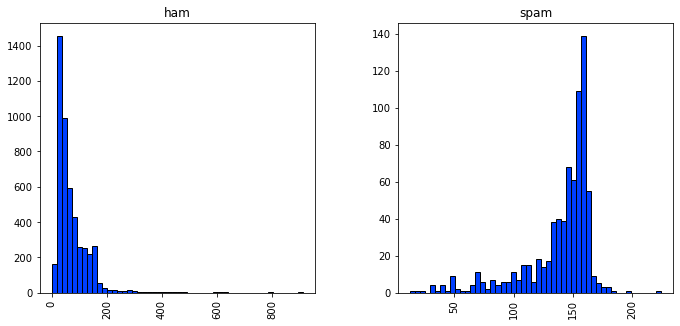

In [38]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})
sms.groupby('label').describe()
sms['length'] = sms['message'].apply(len)
sms.head()
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

# Выполнить предварительную обработку текстовых данных, удалить пунктуацию и стоп-слова, а затем преобразовать текст в числовой формат с использованием TF-IDF для последующего анализа и обучения моделей машинного обучения

In [39]:
text_feat = sms['message'].copy()
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)
text_feat = text_feat.apply(text_process)
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(text_feat)

# Разделить признаки features (которые были преобразованы из текстовых данных с использованием TF-IDF) и метки sms['label'] на обучающий и тестовый наборы данных с помощью функции train_test_split. Создать различные классификаторы машинного обучения, включая SVC, KNeighborsClassifier, MultinomialNB, DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, и ExtraTreesClassifier. Создать словарь clfs, где каждому классификатору присваивается метка для идентификации. Определить функцию train_classifier(clf, feature_train, labels_train) для обучения классификатора clf на обучающем наборе данных feature_train с соответствующими метками labels_train. Определить функцию predict_labels(clf, features) для предсказания меток с использованием обученного классификатора clf на входных признаках features


In [40]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}
def train_classifier(clf, feature_train, labels_train):
    clf.fit(feature_train, labels_train)
def predict_labels(clf, features):
    return (clf.predict(features))

# Создать пустой список pred_scores для хранения оценок производительности различных классификаторов и словарь pred_dict для хранения оценок точности классификации каждого классификатора.Для каждого классификатора v из словаря clfs выполнить следующие действия: обучить классификатор v на обучающем наборе данных features_train с соответствующими метками labels_train, предсказать метки с использованием обученного классификатора v на тестовых признаках features_test, рассчитать точность классификации, сравнивая предсказанные метки с фактическими метками тестового набора данных с помощью функции accuracy_score. Для каждого классификатора k создать запись в словаре pred_dict. Создать объект DataFrame df на основе словаря pred_dict. Выполнить построение столбчатой диаграммы, на которой отображается точность классификации каждого классификатора

D:\Anakonda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


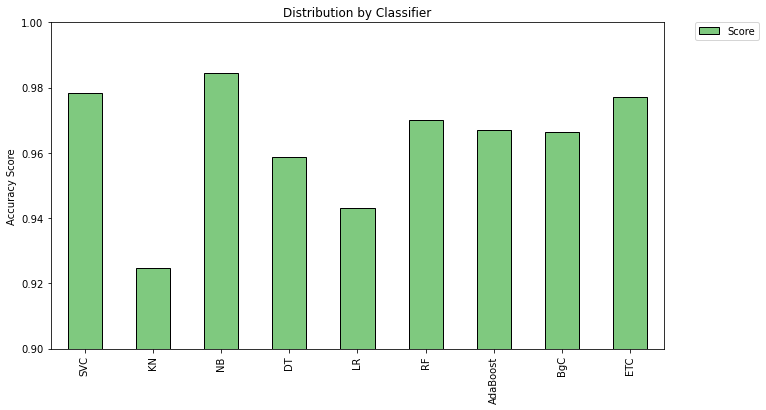

In [41]:
pred_scores = []
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))
    pred_dict[k]=[accuracy_score(labels_test,pred)]
df = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score'])
df
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Создать функцию stemmer, которая принимает текст text в виде строки. В функции stemmer текст разбивается на отдельные слова и каждое слово подвергается стеммингу с использованием алгоритма SnowballStemmer для английского языка.  Применить функцию stemmer к каждому элементу в Series text_feat, которые представляют собой текстовые сообщения. Создать объект features, который представляет TF-IDF векторы для текстовых сообщений после применения стемминга.Далее данные разделить на обучающий и тестовый наборы признаков и меток с использованием train_test_split.Для каждого классификатора из словаря clfs выполнить обучение на обучающем наборе и предсказание меток на тестовом наборе. Точность классификации для каждого классификатора вычислить с помощью функции accuracy_score и записать в словарь pred_dict с меткой классификатора k

In [42]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words
text_feat = text_feat.apply(stemmer)
features = vectorizer.fit_transform(text_feat)
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_dict[k]=[accuracy_score(labels_test,pred)]

D:\Anakonda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# Выполнить сравнение различных классификаторов для определения, какой из них лучше справляется с задачей классификации текстовых сообщений на спам и не спам. Измерить точность каждого классификатора и визуализировать результаты сравнения с использованием столбчатой диаграммы

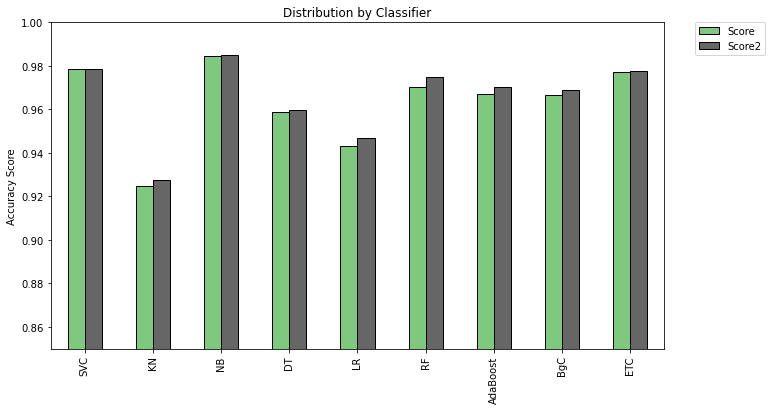

In [43]:
df2 = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score2'])
df = pd.concat([df,df2],axis=1)
df
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Создать ансамбль классификаторов, используя метод голосования с мягким голосованием (soft voting). Ансамбль включает в себя несколько различных классификаторов, таких как BaggingClassifier (BgC), ExtraTreesClassifier (ETC), RandomForestClassifier (RF) и AdaBoostClassifier (Ada). Затем обучить ансамбль на обучающих данных (features_train, labels_train) и использовать его для предсказания меток на тестовых данных (features_test). Вывести точность предсказаний, оценивая, насколько хорошо ансамбль классификаторов справляется с задачей классификации


In [44]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')
eclf.fit(features_train,labels_train)
pred = eclf.predict(features_test)
print(accuracy_score(labels_test,pred))

D:\Anakonda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.9820574162679426
